In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
df = pd.read_csv('./data/names.csv')
data = ' '.join(df.name.tolist())

In [3]:
df.head()

,name,gender,id
0,Emma,F,20799
1,Olivia,F,19674
2,Sophia,F,18490
3,Isabella,F,16950
4,Ava,F,15586


In [4]:
# data I/O
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 237097 characters, 53 unique.


In [5]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [6]:
X_train = np.zeros((len(data), len(chars)))

In [7]:
char_id = np.array([chars.index(c) for c in data])

In [8]:
X_train[np.arange(len(X_train)), char_id] = 1

In [9]:
y_train = np.roll(char_id,-1)

In [10]:
X_train.shape

(237097, 53)

In [11]:
y_train.shape

(237097,)

## Build a RNN model

In [12]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc_x = nn.Linear(input_size, hidden_size)
        self.fc_h = nn.Linear(hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    def forward(self, X, h):
        x_out = self.fc_x(X)
        h_out = self.fc_h(h)
        h_new = self.tanh(x_out + h_out)
        out = self.fc_out(h_new)
        
        return out, h_new
    
    def init_h(self):
        return torch.zeros(self.fc_x.out_features)

In [13]:
#rnn(torch.from_numpy(X_train[0]).float(), torch.zeros(128))

In [14]:
rnn = CharRNN(vocab_size, 128, vocab_size)

In [15]:
loss_fn = nn.CrossEntropyLoss()

In [16]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001)

In [17]:
def get_batch(X=X_train, y=y_train, batch_size=seq_length):
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()
    for i in range(0, len(y), batch_size):   
        id_stop = i+batch_size if i+batch_size < len(X) else len(X)
        yield([X[i:id_stop], y[i:id_stop]])

In [18]:
print(5)

5


In [33]:
def sample_chars(X_seed, h_prev, length=20):
    for p in rnn.parameters():
        p.requires_grad = False
    X_next = X_seed
    results = []
    for i in range(length):        
        y_score, h_prev = rnn(X_next, h_prev)
        y_prob = nn.Softmax(0)(y_score).detach().numpy()
        y_pred = np.random.choice(chars,1, p=y_prob).item()
        results.append(y_pred)
        X_next = torch.zeros_like(X_seed)
        X_next[chars.index(y_pred)] = 1
        #print(f'{i} th char:{y_pred}')
    for p in rnn.parameters():
        p.requires_grad = True
    return ''.join(results)

In [34]:
for p in rnn.parameters():
    print(p.requires_grad)

True
True
True
True
True
True


In [35]:
for epoch in range(1):
    losses = []
    for batch in get_batch(X_train, y_train, seq_length):           
        X_batch, y_batch = batch
        h_prev = rnn.init_h()
        for ch_id in range(len(X_batch)):
            y_score, h_prev = rnn(X_batch[ch_id], h_prev)
            loss = loss_fn(y_score.view(1,-1), y_batch[ch_id].view(1))
            losses.append(loss.item())
            optimizer.zero_grad()            
            loss.backward(retain_graph=True)
            optimizer.step()
            if len(losses)%1000==0:
                print(f'Running Avg Loss:{np.mean(losses[-1000:])} at epoch: {epoch}')  
                print(sample_chars(X_batch[ch_id], h_prev, 200))

Running Avg Loss:2.592132171571255 at epoch: 0
yB Nhaen elga  uasa EAbsdNn AoBedCnooh kaela GoeoiLHog aslbnlLlutaiKonBtideOhaL JalllL LrgrnNnuahvykdr Salyy h Jlilr Akolin HTryal  eienS Caieden Aeunoa Kpynlsy prora Eola evaa EayenHE Kayldi gmelt  H
Running Avg Loss:2.5209558449387552 at epoch: 0
eeynnSsafMy MialYecliTasonanRnan Jiliy Eielaa Eelea Rasiglne Benala AegemeeReKep auiraNiga Calila Layies Jsliena Asinl  imiene racueynlaae ilbPJra pa Fe Malaa smlley Aysii LoeaLmtaeiee Nleeele Deetn  
Running Avg Loss:2.478430690526962 at epoch: 0
maneB Mrryee Ninna Akclel JrhGni KaegynzA Jlelyn Pedsnn Kaiy sehe wlelea hacyl MasaiiStdzDZldy Kevees  ucasia Llneyla bltisABS Roaghl L AolleeNDaeSnisAtihn  elemeDk lelia Fsnly Iarilii LeuarethKn  nly
Running Avg Loss:2.4038646564781665 at epoch: 0
 Sagyava Chnlng JaaaT AnvelKe Matlte Aal sila Ariany Knmila Ca Karaa GKileke Gielh Aila JLzeio Aa KiliiLy Haiaa Malleay  vnei Noyia Aeiaa Arnetn Mia Mala eTRnce Aaia Jlee mtrenn Beria Ete LEsa Feleen 
Runnin

KeyboardInterrupt: 

(array([ 4.,  5., 17., 24., 17., 22., 17., 12.,  7.,  3.]),
 array([-0.92588985, -0.74122807, -0.55656629, -0.3719045 , -0.18724272,
        -0.00258094,  0.18208084,  0.36674262,  0.5514044 ,  0.73606619,
         0.92072797]),
 <a list of 10 Patch objects>)

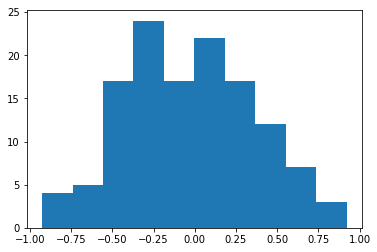

In [36]:
plt.hist(h_prev.detach().numpy())

In [37]:
X_seed = X_batch[ch_id]

In [38]:
print(sample_chars(X_seed, rnn.init_h(), 10000))

a Miseyn Yylsrh Arltncya Byaleh Rarie Nalesa Arynyya Ranriplvht Loni Satrine Biten Erie Aalianaer Jua Kariee Larjesbe Nridii Slinna Vayken eteseyn Aliae Asmyata Keyn Kraoieh Mutie Bmleeiia Zlie Kofeaknnae JanhaPLisnnn Imtse Aaytion Viec naya Drerltliv CTan aomen Lan Aaineen Hvaea Alao Area Byeoie Sstlesa Taiin eeyle  dmrarnn Reina oyr yleylna AaynenM Kensue Aoe Saina Lmyva Cadhlia Rala TJile Koinane Arey Milyan Rata vnsraen Aoanna Aosloany Srzya Nekoee Sorie A iirinnle Saayne Klaehne ryonvehlRe Sekina Eciblnne Jeane Blyyay Mantyh Msae Canooy Saco BhlynJaSveci Aadiza Deyran Yaialglniy Gvlao Dailein Jaelyn Armeip Mdnnna Aysdna Aahita SmmieIC rmenlee Ainia Raoay oahato rielan Sbaveaei Memlon Jay Mansy Come Deioe Asieei Hdallna Smibyn Koyson Jade Jaclan Kalles sallyna CoorahcAHna qey Hoyslet Dalsk Gargiy nm Oand Mrknyan RasynLyn AealahlCbRey Bian Nreiseia Vynr Lann Irityy Iaili Jonion KayDsynn Pense pnna Sarssa Lox Laslie AhaVina Kadlenh Darsya Jelean Bimlany Kasntia Aeyle Rata Mcelia AnSl

In [39]:
np.log(80)

4.382026634673881

In [40]:
2.225*25

55.625

In [200]:
X_next = torch.zeros_like(X_seed)

In [201]:
X_next[y_pred]=1

In [202]:
y_score, h_prev = rnn(X_next, h_prev)

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.])

In [116]:
y_score.view(1,-1).shape

torch.Size([1, 53])

In [119]:
y_batch[ch_id].view(1)

tensor([ 49])

In [123]:
loss_fn(y_score.view(1,-1), y_batch[ch_id].view(1))

IndexError: index 6 is out of bounds for dimension 0 with size 6

In [125]:
y_score.view(1,-1)

tensor([[-0.0357,  0.0332,  0.0107,  0.0057, -0.0174, -0.1969, -0.0340,
          0.0583, -0.1455,  0.1751, -0.0706,  0.1280, -0.0751, -0.0068,
          0.0681,  0.0376, -0.1166,  0.0185,  0.0158,  0.0174, -0.0886,
         -0.1260, -0.1418, -0.0454, -0.0296, -0.0099,  0.0042,  0.1124,
         -0.0540,  0.0317, -0.0390, -0.0260, -0.0610,  0.0854, -0.0277,
         -0.0665, -0.2261, -0.0420,  0.0861,  0.0427, -0.0653,  0.0099,
         -0.1085, -0.1096, -0.0630, -0.0732,  0.0298,  0.1485,  0.1238,
         -0.0566, -0.0781, -0.0790,  0.0377]])

In [131]:
y_batch

tensor([  9,   6,   9,   1,  34,  44])

In [17]:
Wxh.shape

(100, 53)

In [18]:
Whh.shape

(100, 100)

In [19]:
Why.shape

(53, 100)

In [20]:
bh.shape

(100, 1)

In [10]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [11]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [12]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [21]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

In [28]:
inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

In [30]:
hprev.shape

(100, 1)

In [31]:
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0

In [32]:
t = 0

In [34]:
xs[t] = np.zeros((vocab_size,1))

In [37]:
xs[t][inputs[t]] = 1

In [41]:
np.dot(Wxh, xs[t]).shape

(100, 1)

In [49]:
hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)

In [52]:
import matplotlib.pyplot as plt
% matplotlib inline

In [59]:
ys[t] = np.dot(Why, hs[t]) + by

In [61]:
ys[t].shape

(53, 1)

In [62]:
ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))

In [73]:
-np.log(1.0/3000)*50

400.3183783825123

In [74]:
hprev = hs[t-1]

In [79]:
''.join(ix_to_char[ix] for ix in sample(hprev, 1, 200))

'ikama enaliia Janden Celen Badkia Darine Jumah Jagkida Asmyanat Caima Ediouy Inriserya Janieghebe Jame Giyne Jozabkatgh Alance Jomvi Jorielya Eyah Aillana Kateliuh Babye Makjan Calisse Tynnibele Jaigz'

In [81]:
seed_ix = 1

In [82]:
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []

In [84]:
x.shape

(53, 1)

In [86]:
h = hprev

In [115]:
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)

In [116]:
ix

7

In [120]:
x.shape

(53, 1)

In [121]:
Wxh.shape

(100, 53)

In [122]:
np.dot(Wxh, x).shape

(100, 1)

In [126]:
Wxh.shape

(100, 53)

In [48]:
np.log(vocab_size)*25

99.25729783880305

In [45]:
seq_length

25

In [49]:
hprev = np.zeros((hidden_size,1))

In [51]:
hprev.shape

(100, 1)

In [52]:
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

In [54]:
data[p:p+seq_length]

'Emma Olivia Sophia Isabel'

In [55]:
data[p+1:p+seq_length+1]

'mma Olivia Sophia Isabell'

In [56]:
inputs[0]

44

In [64]:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

----
 PfKTwPfmTLjbeVZCLEYRbGltieocPNNtsnTWVZNjehJnZLQRvvrMFQNpxCxHQncWpvjBYZYqasQfIdjPqtrPTEYDcCOxngJamYZCVpjyxVEIQRCbvbqpYtPM ZNVXcNiIDRixwFDVnkWUscUzu juwCkYuBqHeUVcyiWELKcoIr nr TKNCDpxLGyyKENSvJnmvweRQQ 
----


In [66]:
loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)

In [100]:
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0

In [101]:
t=0

In [102]:
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)

In [141]:
hs[-1].shape

(100, 1)

In [138]:
ps[t][targets[t]][0]

0.0398582039920804

In [132]:
ps[t]

array([[1.22462687e-02],
       [3.70884873e-04],
       [1.47718282e-01],
       [4.91778089e-04],
       [1.43579039e-02],
       [1.94613594e-03],
       [3.98582040e-02],
       [1.83239784e-03],
       [1.40377295e-03],
       [2.25524356e-03],
       [1.86338027e-02],
       [1.82163330e-03],
       [1.36034842e-03],
       [5.34832575e-03],
       [5.31882994e-03],
       [2.56723943e-02],
       [2.08954666e-01],
       [1.67814105e-04],
       [5.43953948e-02],
       [1.23416029e-02],
       [2.71522941e-02],
       [7.07506732e-04],
       [3.90479874e-03],
       [3.07619937e-03],
       [6.03594339e-04],
       [2.60599790e-02],
       [3.70108202e-05],
       [2.20467155e-03],
       [8.62683131e-03],
       [6.98119822e-04],
       [5.34681858e-03],
       [2.66708994e-03],
       [1.11460252e-02],
       [1.62131224e-03],
       [4.59798728e-03],
       [2.41688939e-03],
       [7.15391514e-04],
       [1.00846412e-03],
       [7.64864017e-04],
       [1.19025338e-02],


In [126]:
ps[t].argmax()

16

In [117]:
Wxh[:,10]

array([-0.11848706, -0.05649749,  0.02691294,  0.19014995,  0.07061441,
       -1.16252144,  0.12697324, -0.08889963, -0.06267175, -0.40105323,
       -0.18747102, -0.18140617,  0.07432117,  0.34334437,  0.06726984,
        0.20165935,  0.32747234,  0.04495337,  0.1142929 , -0.05521551,
        0.00885307,  0.33516984,  0.13067932, -0.10904185,  0.19814699,
        0.0913149 , -0.06236525, -0.01253117,  0.41185781, -0.3912567 ,
       -0.1494085 ,  0.36435163, -0.44824475, -0.09278199,  0.34402929,
       -0.15928979, -0.26921809,  0.05811367, -0.13787257,  0.20121986,
        0.01388096,  0.07998907,  0.05387593,  0.0689815 ,  0.26390591,
        0.0065182 , -0.09641561,  0.20798219,  0.07988806,  0.20825779,
       -0.26811509, -0.03696904, -0.16780612, -0.38446364,  0.28463213,
        0.14157797, -0.19357392, -0.16630077,  0.11378831,  0.25725707,
        0.17818427,  0.008875  , -0.06520907,  0.12799508,  0.22632408,
       -0.17792747,  0.19119546, -0.04671774, -0.45145593,  0.05

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0:
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

In [ ]:
df = pd